In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats 
from shapely.geometry import Point
import shapely.speedups

plt.style.use('ggplot')
shapely.speedups.enable()
%matplotlib inline

In [4]:
nypd = pd.read_csv('../data/nypd.csv')
nypd['Date'] = pd.to_datetime(nypd['OCCUR_DATE'])
nypd = nypd.drop('OCCUR_DATE', axis=1)

In [5]:
nypd['Month'] = nypd.Date.dt.month 


In [6]:
nypd['Year'] = nypd.Date.dt.year

In [7]:
#dropping string object, need geometry
nypd = nypd.drop('Lon_Lat', axis=1)


In [8]:
#adding geometry objects for mapping
nypd['points'] = nypd.apply(lambda srs: Point( srs['Longitude'] , srs['Latitude']), axis=1)

In [127]:
#city-wide map
nyc = gpd.read_file('../data/map.geojson')

In [370]:
#making a geopandas dataframe to plot spatially 
geo_ny = gpd.GeoDataFrame(nypd)
geo_ny = geo_ny.set_geometry('points')

In [371]:
#merging nyc neighborhoods dataset with shooting dataset on coordinates being within the polygons of nyc dataset
whole = gpd.sjoin(geo_ny, nyc, how='left', op='within')
whole = whole.drop(['JURISDICTION_CODE','PERP_SEX', '@id', 'index_right'], axis=1)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


In [361]:
whole = whole.drop(['OCCUR_TIME', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'VIC_AGE_GROUP', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD'], axis =1)

In [376]:
whole = whole.drop('BORO', axis = 1)

In [378]:
#all murders
geo_k = gpd.GeoDataFrame(whole.loc[whole.STATISTICAL_MURDER_FLAG == True], geometry = 'points')

In [385]:
#dividing dataframes into boroughs
bronx = gpd.GeoDataFrame(whole.loc[whole.borough == 'Bronx'], geometry = 'points')
brooklyn = gpd.GeoDataFrame(whole.loc[whole.borough == 'Brooklyn'], geometry = 'points')
queens = gpd.GeoDataFrame(whole.loc[whole.borough == 'Queens'], geometry = 'points')
staten = gpd.GeoDataFrame(whole.loc[whole.borough == 'Staten Island'], geometry = 'points')
manhattan = gpd.GeoDataFrame(whole.loc[whole.borough == 'Manhattan'], geometry = 'points')

In [11]:
#dividing borough dataframes into 
bx_k = bronx.loc[bronx.STATISTICAL_MURDER_FLAG == True]
brooklyn_k = brooklyn.loc[brooklyn.STATISTICAL_MURDER_FLAG == True]
queens_k = queens.loc[queens.STATISTICAL_MURDER_FLAG == True]
staten_k = staten.loc[staten.STATISTICAL_MURDER_FLAG == True]
manhattan_k = manhattan.loc[manhattan.STATISTICAL_MURDER_FLAG == True]



In [12]:
#assigning total murders by borough
bx_killed, bk_killed, queens_killed, staten_killed, manhattan_killed = bx_k.count()['INCIDENT_KEY'], brooklyn_k.count()['INCIDENT_KEY'], queens_k.count()['INCIDENT_KEY'], staten_k.count()['INCIDENT_KEY'], manhattan_k.count()['INCIDENT_KEY']

In [386]:
#dividing dataset into pre-2013, post-2013, and 2013
pre = gpd.GeoDataFrame(whole.loc[whole.Year < 2013], geometry = 'points')
post = gpd.GeoDataFrame(whole.loc[whole.Year > 2013], geometry = 'points')
stop = gpd.GeoDataFrame(whole.loc[whole.Year == 2013], geometry = 'points')

In [387]:
#pre-2013, post-2013, 2013 murders
pre_k = gpd.GeoDataFrame(pre[pre.STATISTICAL_MURDER_FLAG == True], geometry = 'points')
post_k = gpd.GeoDataFrame(post[post.STATISTICAL_MURDER_FLAG == True], geometry = 'points')
stop_k = gpd.GeoDataFrame(stop[stop.STATISTICAL_MURDER_FLAG == True], geometry = 'points')



In [368]:
len(geo_ny) , len(whole)

(23568, 23568)

In [389]:
#geodataframes of kills by boro
geo_bronx = geo_k.loc[geo_k.borough == 'Bronx']
geo_bk = geo_k.loc[geo_k.borough == 'Brooklyn']
geo_qns = geo_k.loc[geo_k.borough == 'Queens']
geo_st = geo_k.loc[geo_k.borough == 'Staten Island']
geo_mn = geo_k.loc[geo_k.borough == 'Manhattan']

In [390]:
#borough maps
bronx_map = nyc[nyc.borough == 'Bronx']
brooklyn_map = nyc[nyc.borough == 'Brooklyn']
queens_map = nyc[nyc.borough == 'Queens']
manhattan_map = nyc[nyc.borough == 'Manhattan']
staten_map = nyc[nyc.borough == 'Staten Island']

In [391]:
#setting all geodataframes to same coordinate referencing system
gdfs = [geo_k, pre, post, stop, pre_k, post_k, stop_k, geo_bronx, geo_bk, geo_qns, geo_st, geo_mn, geo_ny,bronx_map, brooklyn_map, queens_map, manhattan_map, staten_map, brooklyn, bronx, queens, manhattan, staten]
for df in gdfs:
    df.crs = {'init': 'epsg:4326'}


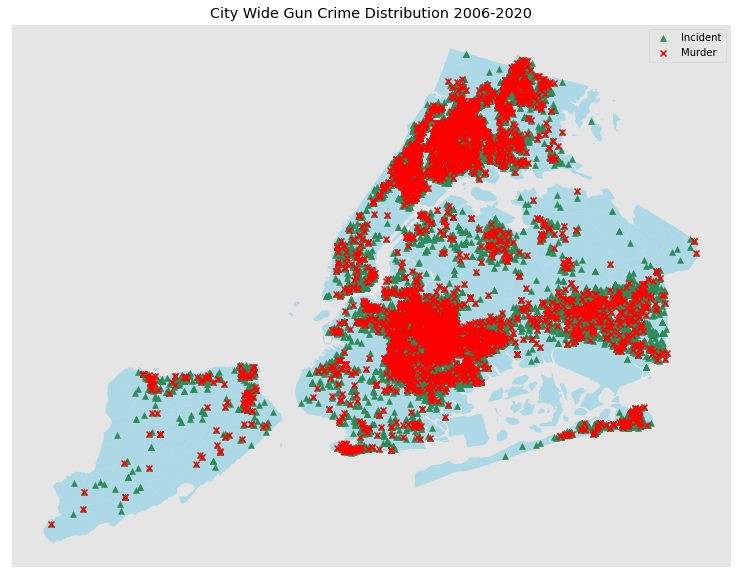

In [395]:
fig, ax = plt.subplots(figsize=(15, 10))
nyc.plot(color = 'lightblue', ax=ax)
geo_ny.plot(marker = '^', color = 'seagreen', ax = ax, label = 'Incident')
geo_k.plot(marker = 'x', color = 'red', ax = ax, label = 'Murder')
ax.set_title('City Wide Gun Crime Distribution 2006-2020')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('../images/City-Wide.png');

In [353]:
total_deaths_by_year = []
for name, group in killed.groupby('Year'):
    total_deaths_by_year.append(group.count()['INCIDENT_KEY'])

In [63]:
total_deaths_by_year = np.array(total_deaths_by_year)

In [64]:
total_incidents_by_year = []
for name, group in nypd.groupby('Year'):
    total_incidents_by_year.append(group.count()['INCIDENT_KEY'])
    

In [65]:
total_incidents_by_year = np.array(total_incidents_by_year)

In [66]:
rate_of_murder = total_deaths_by_year / total_incidents_by_year 

In [68]:
murder_rate = pd.Series(rate_of_murder, index=range(2006, 2021))

In [73]:
#initializing a dataframe for yearly stats
yearly = pd.DataFrame(murder_rate, columns = ['murder_rate'])

In [78]:
yearly['total_deaths'] = total_deaths_by_year
yearly['total_incidents_by_year'] = total_incidents_by_year 

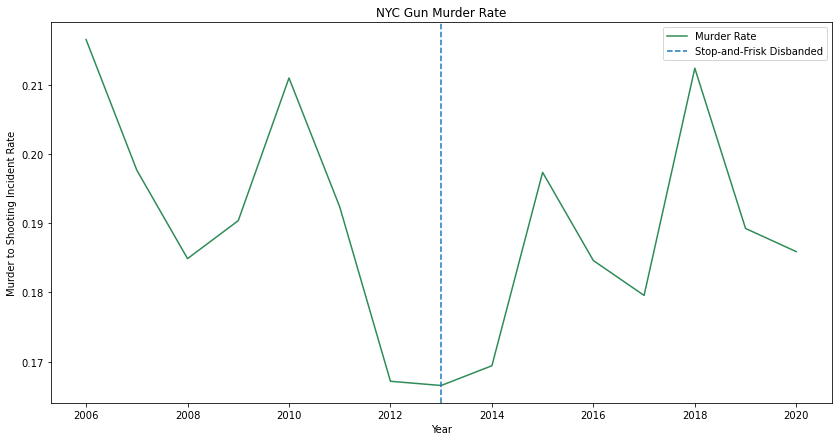

In [91]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yearly.index, yearly.murder_rate, color='seagreen', label='Murder Rate')
ax.axvline(2013, linestyle = '--', label = 'Stop-and-Frisk Disbanded')
ax.set_title('NYC Gun Murder Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Murder to Shooting Incident Rate')
plt.savefig('../images/Murder-Rate.png')
ax.legend();

In [121]:
#calculates borough murder rate by year 
def kill_stat(df, df_k):
    incidents = []
    deaths = []
    for name, group in df.groupby('Year'):
        incidents.append(group.count()['INCIDENT_KEY'])
    for name, group in df_k.groupby('Year'):
        deaths.append(group.count()['INCIDENT_KEY'])
    incidents = np.array(incidents)
    deaths = np.array(deaths)
    return deaths/incidents

In [125]:
yearly['Brooklyn'] = kill_stat(brooklyn, brooklyn_k)
yearly['Queens'] = kill_stat(queens, queens_k)
yearly['Manhattan'] = kill_stat(manhattan, manhattan_k)
yearly['Staten Island'] = kill_stat(staten, staten_k)

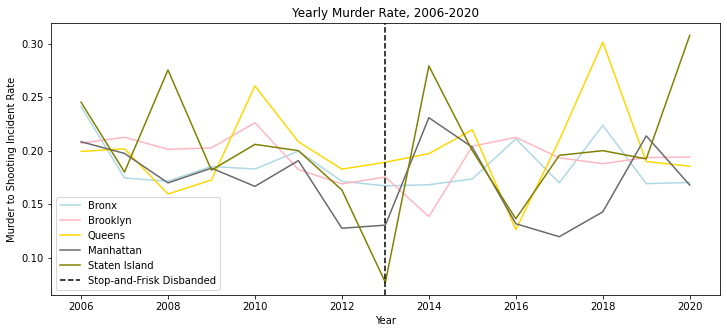

In [276]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(yearly.index, yearly.Bronx,color = 'lightblue', label = 'Bronx')
ax.plot(yearly.index,yearly.Brooklyn, color = 'lightpink', label = 'Brooklyn')
ax.plot(yearly.index,yearly.Queens, color = 'gold', label = 'Queens')
ax.plot(yearly.index,yearly.Manhattan, color='dimgray', label = 'Manhattan')
ax.plot(yearly.index,yearly['Staten Island'], color = 'olive', label = 'Staten Island')
ax.set_title('Yearly Murder Rate, 2006-2020')
ax.axvline(2013, linestyle = '--', color = 'black', label = 'Stop-and-Frisk Disbanded')
ax.set_xlabel('Year')
ax.set_ylabel('Murder to Shooting Incident Rate')
ax.legend()
plt.savefig('../images/yearly-rate.png');


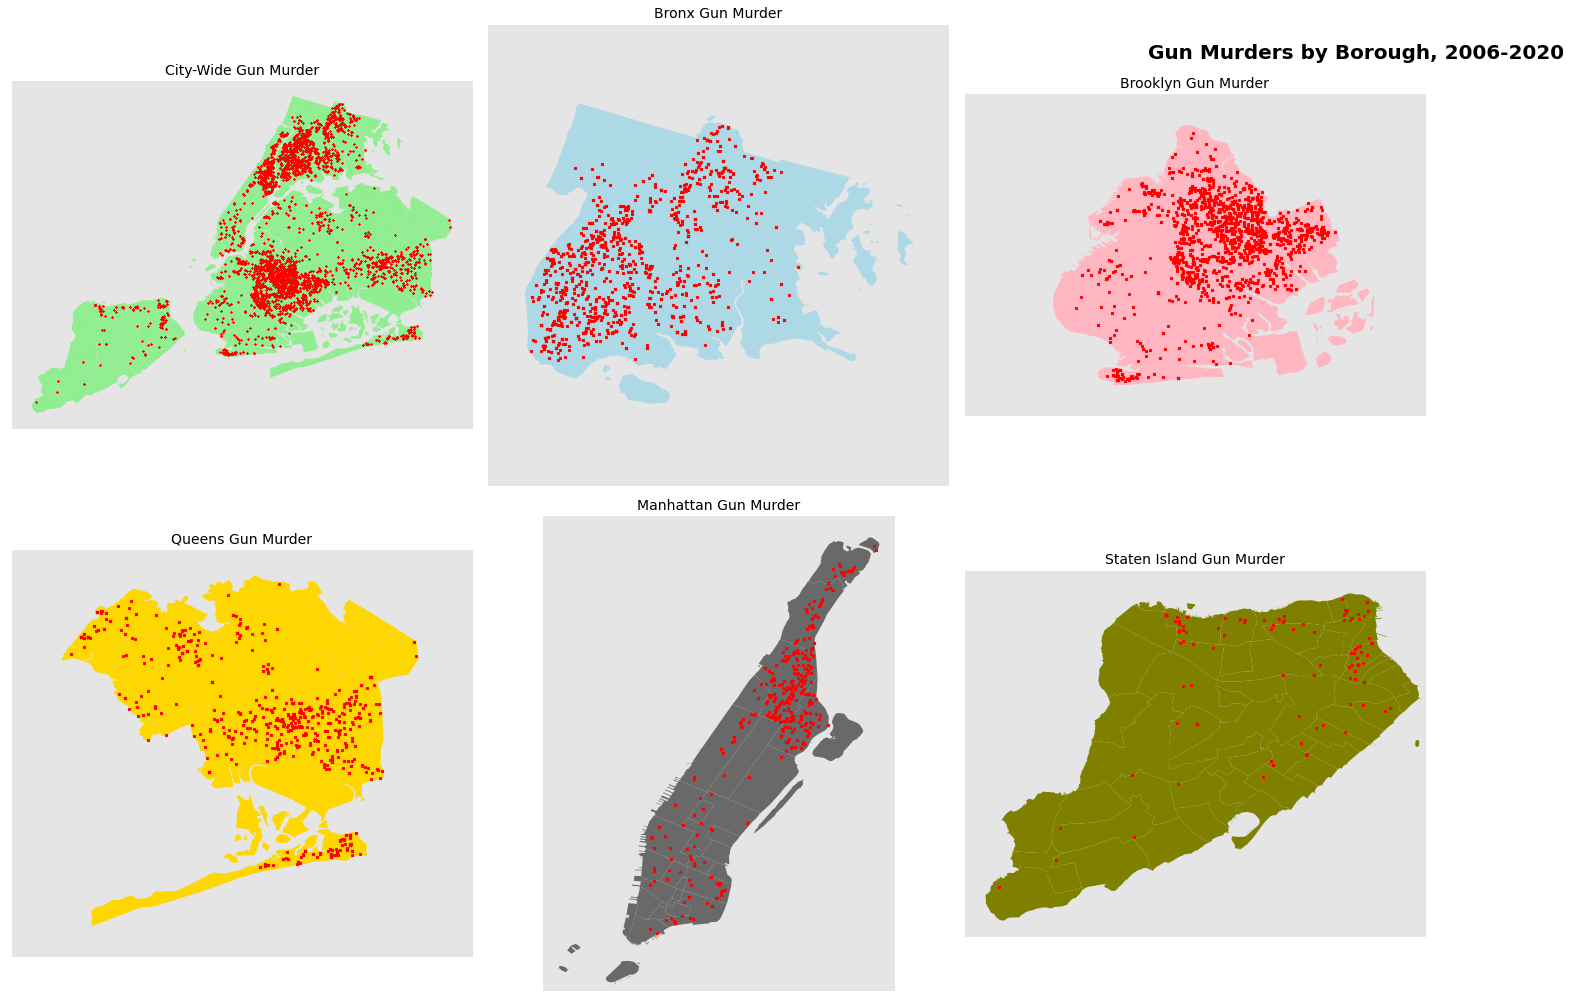

In [396]:
fig, axs = plt.subplots(2, 3, figsize=(20, 14))
axs=axs.flatten()

nyc.plot(ax=axs[0], color = 'lightgreen')
geo_k.plot(ax=axs[0], marker = "x", color = 'red', markersize = 2)
axs[0].set_title('City-Wide Gun Murder', fontsize=14)


bronx_map.plot(ax=axs[1], color = 'lightblue')
geo_bronx.plot(ax=axs[1], color = 'red', marker = 'x', markersize=6)
axs[1].set_title('Bronx Gun Murder', fontsize=14)
axs[1].set_ylim(40.75, 40.95)
axs[1].set_xlim(-73.95, -73.75)


brooklyn_map.plot(ax=axs[2], color = 'lightpink')
geo_bk.plot(ax=axs[2], color = 'red', marker = 'x', markersize = 6)
axs[2].set_title('Brooklyn Gun Murder', fontsize=14)
axs[2].set_ylim(40.55, 40.76)
axs[2].set_xlim(-74.1, -73.8)


queens_map.plot(ax=axs[3], color = 'gold')
geo_qns.plot(ax=axs[3], color = 'red', marker = 'x', markersize = 6)
axs[3].set_title('Queens Gun Murder', fontsize=14)
axs[3].set_xlim(-74.0, -73.66)
axs[3].set_ylim(40.52, 40.82)

manhattan_map.plot(ax=axs[4], color = 'dimgray')
geo_mn.plot(ax=axs[4], color = 'red', marker = 'x', markersize = 6)
axs[4].set_title('Manhattan Gun Murder', fontsize=14)
axs[4].set_xlim(None,-73.9)
axs[4].set_ylim(40.68, None)

staten_map.plot(ax=axs[5], color = 'olive')
geo_st.plot(ax=axs[5], color = 'red', marker = 'x', markersize = 6)
axs[5].set_title('Staten Island Gun Murder', fontsize=14)
axs[5].set_xlim(None, -74.05)
axs[5].set_ylim(None, 40.66)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.text(.8, .94, 'Gun Murders by Borough, 2006-2020', fontsize=20, fontweight='bold')

fig.tight_layout()
plt.savefig('../images/borough-murders.png');

In [407]:
#getting pre 2013, post2013, and 2013 boro values of total incidents, total kills 
pre_boro_totals = dict()
post_boro_totals = dict()
stop_boro_totals = dict()
for name, group in pre.groupby('borough'):
    pre_boro_totals[name] = group.count()[0]
for name, group in post.groupby('borough'):
    post_boro_totals[name] = group.count()[0]
for name, group in stop.groupby('borough'):
    stop_boro_totals[name] = group.count()[0]



In [410]:
def dict_to_series(dct):
    idx = []
    vals = []
    for k, v in dct.items():
        idx.append(k)
        vals.append(v)
    out = pd.Series(vals, index=idx)

        